# 深度學習期末報告-自動光學檢查 AOI
### 蔡宗宏 405031543 
### 授課老師 邵皓強

## 安裝環境與環境建置

- Google CoLab
- Python3 GPU
- Pytroch

## 資料準備

### 連動 google drive



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

%matplotlib inline

In [3]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.6.0+cu101
Torchvision Version:  0.7.0+cu101


### Unzip aoi.zip to cloud environment

In [4]:
cloud_path = '/content/drive/My Drive/ML_assets'
zip_path = '/content/drive/My Drive/ML_assets/aoi.zip'
to_path = '/_temp'

In [5]:
from zipfile import ZipFile

def unzip(paths, to_path):
  """paths: list, to_path"""
  for path in paths:
    if path.endswith('.zip'):
      with ZipFile(path, 'r') as zipObj:
        zipObj.extractall(to_path)
        childs = ['{}/{}'.format(to_path, file_name) for file_name in zipObj.namelist()]
        unzip(childs, to_path)

unzip([zip_path], to_path)

### 訓練資料

In [6]:
df = pd.read_csv('{}/{}'.format(to_path, 'train.csv'))
df.head()

,ID,Label
0,train_00000.png,0
1,train_00001.png,1
2,train_00002.png,1
3,train_00003.png,5
4,train_00004.png,5


### 客製化 AOI 資料集



In [7]:
class aoiDataset(Dataset):
    def __init__(self, root, X, y, transform):
        ##############################################
        ### Initialize paths, transforms, and so on
        ### data list -> DataFrame ID, Label
        ##############################################
        self.transform = transform
        # 
        # load image path and annotations
        self.imgs = X
        self.imgs = [ '{}/{}'.format(root, img) for img in self.imgs ]
        self.lbls = y
        assert len(self.imgs) == len(self.lbls), 'mismatched length!'
        print ('Total data split: {}'.format(len(self.imgs)))
        
    def __getitem__(self, index):
        ##############################################
        # 1. Read from file (using numpy.fromfile, PIL.Image.open)
        # 2. Preprocess the data (torchvision.Transform).
        # 3. Return the data (e.g. image and label)
        ##############################################
        imgpath = self.imgs[index]
        img = Image.open(imgpath).convert('RGB')
        lbl = int(self.lbls[index])
        if self.transform is not None:
            img = self.transform(img)
        return img, lbl
        
    def __len__(self):
        ##############################################
        ### Indicate the total size of the dataset
        ##############################################
        return len(self.imgs)



### 訓練模型主程式

>參考來源： https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [8]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    #模型參考 https://keras.io/api/applications/
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "resnet152":#經驗證此模型正確率最高
        """ Resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [11]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [12]:
# 
def train_model(model, dataloaders, criterion, optimizer, num_epochs=75, is_inception=False):#原num_epochs=25
    since = time.time()

    history = {
        'loss_val': [],
        'loss_train': [],
        'acc_val': [],
        'acc_train': [],
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                history['acc_val'].append(epoch_acc)
                history['loss_val'].append(epoch_loss)
            else:
                history['acc_train'].append(epoch_acc)
                history['loss_train'].append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

Model setting

In [13]:
# Top level data directory. Here we assume the format of the directory conforms
# Models to choose from [resnet50, resnet152, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet152"#這裡可以用不同的方法(上面的if else都有)，下面所有的數字都能˙改改看

# Number of classes in the dataset
num_classes = 6
#https://keras.io/api/utils/python_utils/

# Batch size for training (change depending on how much memory you have)
batch_size = 128 #原:16

# Number of epochs to train for
num_epochs = 30 #原:20  #30:0.953947 #50: overfitting 故改變其他參數

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [14]:
model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


### 影像預處理

In [15]:
data_transforms = {
    'train': transforms.Compose([
                transforms.RandomResizedCrop(input_size),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),               
                ]),
    'val': transforms.Compose([
                    transforms.Resize((input_size, input_size)),
                    transforms.CenterCrop(input_size),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225]),
                    ])
}

### Training, Validation and Testing sets.

In [16]:
from sklearn.model_selection import train_test_split

X = np.array(df['ID'])
y = np.array(df['Label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, random_state=100)

In [17]:
# create train/val datasets
root = '{}/{}'.format(to_path, 'train_images')


trainset = aoiDataset(root=root, 
                      X=X_train, y=y_train,
                      transform=data_transforms['train'])
valset = aoiDataset(root=root, 
                      X=X_test, y=y_test,
                      transform=data_transforms['val'])

# create train/val loaders
train_loader = DataLoader(dataset=trainset,
                          batch_size=128, #原:16
                          shuffle=True,
                          num_workers=64) #原:4

val_loader = DataLoader(dataset=valset,
                        batch_size=128,  #原16
                        shuffle=False,
                        num_workers=64)  #原:4

Total data split: 2224
Total data split: 304


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    5     5     1     5


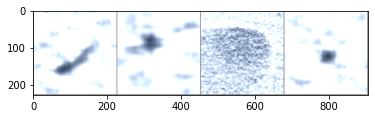

In [18]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels = dataiter.next()

## 檢視資料
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# # print labels
print(' '.join('%5d' % labels[j] for j in range(4)))

https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5

have to freeze the pre-trained layers, so we don’t backprop through them during training.

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Send the model to GPU
model = model.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.

params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer = optim.SGD(params_to_update, lr=0.01, momentum=0.9) #原lr = 0.001

criterion = nn.CrossEntropyLoss()

Params to learn:
	 fc.weight
	 fc.bias


In [20]:
dataloaders = {
    'train': train_loader,
    'val': val_loader
}

model, history = train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs, is_inception=False)


Epoch 0/29
----------
train Loss: 1.0021 Acc: 0.6335
val Loss: 1.0773 Acc: 0.5592

Epoch 1/29
----------
train Loss: 0.4796 Acc: 0.8408
val Loss: 1.3282 Acc: 0.4836

Epoch 2/29
----------
train Loss: 0.3735 Acc: 0.8822
val Loss: 0.8954 Acc: 0.6316

Epoch 3/29
----------
train Loss: 0.3213 Acc: 0.8948
val Loss: 0.3402 Acc: 0.8750

Epoch 4/29
----------
train Loss: 0.3250 Acc: 0.8876
val Loss: 0.2611 Acc: 0.9145

Epoch 5/29
----------
train Loss: 0.2678 Acc: 0.9101
val Loss: 0.1939 Acc: 0.9408

Epoch 6/29
----------
train Loss: 0.3264 Acc: 0.8876
val Loss: 0.2508 Acc: 0.9079

Epoch 7/29
----------
train Loss: 0.2893 Acc: 0.8997
val Loss: 0.1863 Acc: 0.9375

Epoch 8/29
----------
train Loss: 0.2809 Acc: 0.9038
val Loss: 0.2158 Acc: 0.9276

Epoch 9/29
----------
train Loss: 0.2708 Acc: 0.9083
val Loss: 0.2105 Acc: 0.9342

Epoch 10/29
----------
train Loss: 0.2701 Acc: 0.9123
val Loss: 0.1886 Acc: 0.9441

Epoch 11/29
----------
train Loss: 0.2870 Acc: 0.8957
val Loss: 0.1641 Acc: 0.9572

Ep

In [32]:
output_path = '{}/{}'.format(cloud_path, 'aoi_{}_202001020.pth'.format(model_name))
#print(output_path)
# torch.save colab 會有 error output, 不需要理會
torch.save(model, output_path)

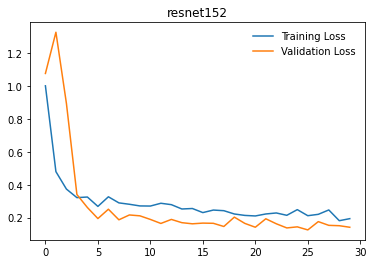

In [33]:
plt.title(model_name)
plt.plot(history['loss_train'], label='Training Loss')
plt.plot(history['loss_val'], label='Validation Loss')
# plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()
#https://www.zhihu.com/question/58200419

## 驗證 Testing Set

In [34]:
df_test = pd.read_csv('{}/{}'.format(to_path, 'test.csv'))
df_test['Label'] = 0

df_test.head()

,ID,Label
0,test_00000.png,0
1,test_00001.png,0
2,test_00002.png,0
3,test_00003.png,0
4,test_00004.png,0


In [38]:
# load model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
output_path = '{}/{}'.format(to_path, output_path)
model = torch.load(output_path)#可能出現bug，不理會也行(可能是原本雲端就有這個model)
model.eval()

FileNotFoundError: ignored

Total data split: 10142


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


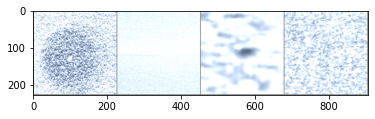

In [39]:
# create train/val datasets
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

test_root = '{}/{}'.format(to_path, 'test_images')


testset = aoiDataset(root=test_root, 
                      X=np.array(df_test['ID']), y=np.array(df_test['Label']),
                      transform=data_transforms['val'])

testloader = DataLoader(dataset=testset,
                        batch_size=64, #原:16
                        shuffle=False,
                        num_workers=16) #原:4


dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:4]))

In [40]:
test_output = []

for inputs, labels in testloader:
    outputs = model(inputs.to(device)) 
    _, predicted = torch.max(outputs, 1)
    test_output += predicted.tolist()

In [41]:
df_output = df_test.copy()
df_output['Label'] = test_output
df_output.head(10)

,ID,Label
0,test_00000.png,1
1,test_00001.png,2
2,test_00002.png,5
3,test_00003.png,1
4,test_00004.png,2
5,test_00005.png,5
6,test_00006.png,5
7,test_00007.png,5
8,test_00008.png,0
9,test_00009.png,2


In [42]:
df_output.to_csv( '{}/{}'.format(cloud_path, 'aoi_{}.csv'.format(model_name)), index=0)